In [1]:
import os
import sys
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
numpy version :  1.14.0
matplotlib version : 2.1.2
pytorch version :  0.4.1
Cuda :  False


In [2]:
batchSize = 512
learningRate = 0.01
epochNum = 5 #gpu 못쓰는 경우 5로 설정해주자
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 학습 데이터
# root      : ./data/mnist 라는 경로에 데이터를 저장
# train     : 학습 데이터를 의미
# download  : 지정한 경로에 데이터를 다운로드 함
# transform : 데이터를 주어진 방법으로 변환함 (28 * 28 사이즈로 잘라내기 -> 텐서로 변환)
dataTrain = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = True,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

# 테스트 데이터
# root      : ./data/mnist 라는 경로에 데이터를 저장
# train     : 테스트 데이터를 의미
# download  : 지정한 경로에 데이터를 다운로드 함
# transform : 데이터를 주어진 방법으로 변환함 (28 * 28 사이즈로 잘라내기 -> 텐서로 변환)
dataTest = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = False,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

# 학습 데이터 로더
# dataset    : 학습 데이터를 불러옴
# batch_size : 위에서 지정한 batchSize 만큼 데이터를 불러옴
# shuffle    : 랜덤한 순서로 데이터를 불러옴
trainLoader = torch.utils.data.DataLoader(dataset = dataTrain, 
                                         batch_size = batchSize, 
                                         shuffle = True)

# 테스트 데이터 로더
# dataset    : 테스트 데이터를 불러옴
# batch_size : 위에서 지정한 batchSize 만큼 데이터를 불러옴
# shuffle    : 일정한 순서로 데이터를 불러옴
testLoader = torch.utils.data.DataLoader(dataset = dataTest, 
                                         batch_size = batchSize, 
                                         shuffle = False)

print('[info] batchSize : ', batchSize)
print('[info] # of train batch : ', len(trainLoader))
print('[info] # of test batch : ', len(testLoader))

Processing...
Done!
[info] batchSize :  512
[info] # of train batch :  118
[info] # of test batch :  20


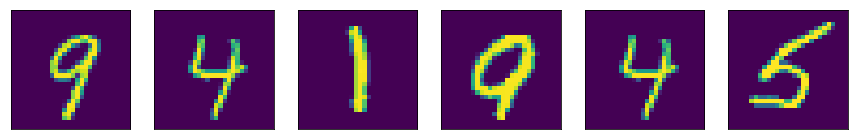

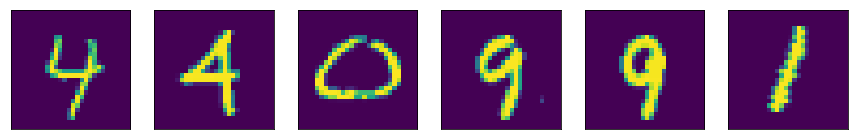

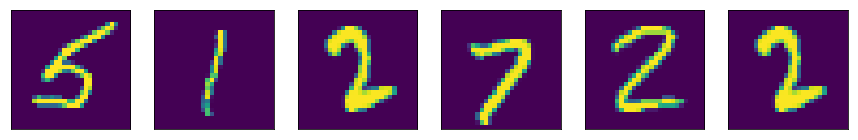

In [4]:
def showImages(image, row):
  
  for _ in range(row):    
    idx = np.random.choice(100, 6)     # 0 ~ 99 의 정수 중 6 개를 임의로 선택
    images =image.numpy()[idx]         # 선택된 index 에 해당하는 이미지를 가져옴
    
    plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성
    
    for i in range(161, 167):    
    
        plt.subplot(i)
        plt.imshow(images[i - 161])
        plt.xticks([])
        plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(trainLoader): 
    showImages(image.squeeze(), 3)
    break

모델을 구현합니다.

모델은 hidden layer 가 2 개인 fully connected neural network 입니다.

hidden layer 의 노드 수는 각각 128 개, 64 개 이며, activation function 은 sigmoid 입니다.

In [7]:
class NeuralNetwork(nn.Module):                   # 모델 클래스를 선언
  
    def __init__(self):
        super(NeuralNetwork, self).__init__()        # nn.Module 을 비롯해 상위 클래스의 생성자를 호출 (문법입니다)

        self.hiddenLayer1 = nn.Linear(28 * 28, 128)  # 28 * 28 = 784 픽셀 (차원) 의 데이터를 받아 128 차원 벡터로 출력하는 레이어
        self.hiddenLayer2 = nn.Linear(128, 64)       # 128 차원의 데이터를 받아 64 차원 벡터로 출력하는 레이어
        self.outputLayer = nn.Linear(64, 10)         # 64 차원의 데이터를 받아 10 차원 벡터로 출력하는 레이어
        self.sigmoid = nn.Sigmoid()                  # sigmoid activation function

    def forward(self, x):                          # 데이터를 받아 예측 결과를 출력하는 메소드 
    
        z2 = self.hiddenLayer1(x)                    # 첫 번째 hidden layer 를 통과한 결과
        a2 = self.sigmoid(z2)                        # 위의 값을 sigmoid 에 통과한 결과

        z3 = self.hiddenLayer2(a2)                   # 두 번째 hidden layer 를 통과한 결과
        a3 = self.sigmoid(z3)                        # 위의 값을 sigmoid 에 통과한 결과

        z4 = self.outputLayer(a3)                    # 마지막 layer 를 통과한 결과
        y = self.sigmoid(z4)                         # 위의 값을 sigmoid 에 통과한 결과 (최종 출력)

        return y

In [8]:
model = NeuralNetwork().to(device)                      # 모델을 생성하고 GPU 로 전송

model.eval()                                            # 모델을 테스트 모드로 전환 (학습 때와 테스트 때의 forward 기능이 달라야 하는 경우가 존재합니다, 이후에 배울 예정입니다.)

with torch.no_grad():                                   # Gradient 계산 x (테스트할 때에는 gradient 가 필요 없으므로 메모리 절약을 위해 gradient 계산을 하지 않습니다.)

    correct = 0
    total = 0

    for images, labels in testLoader:
    
        images = images.reshape(-1, 28 * 28).to(device)     # 가로 28, 세로 28 의 2 차원 MNIST 이미지를 784 차원의 1 차원 벡터로 변환하고 GPU 로 전송
        labels = labels.to(device)                          # MNIST 데이터의 정답, GPU 로 전송

        outputs = model(images)                             # MNIST 이미지가 모델을 통과하고 나온 결과 (classification 결과입니다.)
        _, predicted = torch.max(outputs.data, 1)           # classification 결과와 정답을 비교해 맞은 갯수를 셈 (sigmoid output 의 값이 가장 큰 것이 예측된 class 입니다.)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 9.82 %


In [9]:
model.train()                                                          # 모델을 학습 모드로 전환 (학습 때와 테스트 때의 forward 기능이 달라야 하는 경우가 존재합니다, 이후에 배울 예정입니다.)

costFunction = nn.CrossEntropyLoss()                                   # Cross entropy 를 cost function 으로 사용
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)    # Adam 이라는 optimizer 를 사용 (이후에 배울 예정)

totalStep = len(trainLoader)

for epoch in range(epochNum):
  
    for idx, (images, labels) in enumerate(trainLoader):
      
        images = images.reshape(-1, 28 * 28).to(device)                 # 가로 28, 세로 28 의 2 차원 MNIST 이미지를 784 차원의 1 차원 벡터로 변환하고 GPU 로 전송
        labels = labels.to(device)                                      # MNIST 데이터의 정답, GPU 로 전송
        
        # Forward pass
        outputs = model(images)                                         # MNIST 이미지가 모델을 통과하고 나온 결과 (classification 결과입니다.)
        loss = costFunction(outputs, labels)                            # Classification 결과와 실제 정답을 비교해 cost function 값을 계산
        
        # Backward and optimize
        optimizer.zero_grad()                                           # gradient 값을 초기화 (pyTorch 에서는 gradient 를 계산할 때마다 값이 누적됩니다.)
        loss.backward()                                                 # cost function 값을 토대로 gradient 를 계산
        optimizer.step()                                                # 계산한 gradient 값으로 모델의 파라미터를 업데이트
        
        if (idx + 1) % 100 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch + 1, epochNum, idx + 1, totalStep, loss.item()))

Epoch [1/5], Step [100/118] Loss: 1.5622
Epoch [2/5], Step [100/118] Loss: 1.5329
Epoch [3/5], Step [100/118] Loss: 1.4984
Epoch [4/5], Step [100/118] Loss: 1.4948
Epoch [5/5], Step [100/118] Loss: 1.4799


In [10]:
model.eval()                                            # 모델을 테스트 모드로 전환 (학습 때와 테스트 때의 forward 기능이 달라야 하는 경우가 존재합니다, 이후에 배울 예정입니다.)

with torch.no_grad():                                   # Gradient 계산 x (테스트할 때에는 gradient 가 필요 없으므로 메모리 절약을 위해 gradient 계산을 하지 않습니다.)

    correct = 0
    total = 0
  
    for images, labels in testLoader:
    
        images = images.reshape(-1, 28 * 28).to(device)     # 가로 28, 세로 28 의 2 차원 MNIST 이미지를 784 차원의 1 차원 벡터로 변환하고 GPU 로 전송
        labels = labels.to(device)                          # MNIST 데이터의 정답, GPU 로 전송

        outputs = model(images)                             # MNIST 이미지가 모델을 통과하고 나온 결과 (classification 결과입니다.)
        _, predicted = torch.max(outputs.data, 1)           # classification 결과와 정답을 비교해 맞은 갯수를 셈 (sigmoid output 의 값이 가장 큰 것이 예측된 class 입니다.)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 96.59 %
